In [1]:
import numpy as np
import pandas as pd


from NPIR import NPIR

from sklearn.utils import shuffle
from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn import metrics

import matplotlib.pyplot as plt

import datetime
import warnings
from collections import Counter as Cs
from timeit import default_timer as timer
from datetime import timedelta


import findspark
findspark.init()

########
from numpy import array
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
########

from pyspark import SparkContext
from operator import *
from pyspark import StorageLevel
from pyspark.sql.types import IntegerType, FloatType, BooleanType, StringType, StructType,\
StructField,ArrayType, DataType
from pyspark.sql.functions import udf, log, rand, monotonically_increasing_id, col, broadcast,\
greatest, desc, asc, row_number, avg, mean, least, struct, lit, sequence, sum
from functools import reduce
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, SQLContext, Window, Row, DataFrame
from pyspark import SparkConf

In [2]:
spark = SparkSession.builder.master("local[*]").config("spark.sql.broadcastTimeout", "30000s").\
config("spark.network.timeout","30000s").config("spark.executor.heartbeatInterval","12000000ms").\
config("spark.storage.blockManagerSlaveTimeoutMs","12000001ms").config("spark.driver.maxResultSize","12g").\
config("spark.default.parallelism", "100").config("spark.memory.offHeap.enabled","true").\
config("spark.memory.offHeap.size", "14g").appName("NPIR_Parallel").getOrCreate()

In [3]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
x1,y1 = make_blobs(n_samples=10000, centers=3, n_features=2,
                random_state=1)
data = pd.DataFrame(x1)
data['label'] = y1
data.head()

,0,1,label
0,-3.083894,5.700672,0
1,-8.802585,-5.073890,1
2,-10.022680,-3.134727,1
3,-1.446831,4.514714,0
4,-11.698825,-5.136128,1


In [5]:
data = shuffle(data)
data.head()

,0,1,label
141,-1.381480,4.373999,0
6435,-10.139996,-4.583729,1
2584,-7.541483,-7.598437,2
3283,-6.684569,-8.777886,2
1438,-10.734528,-4.020059,1


In [6]:
data.to_csv('blobs.csv', index=False)

In [7]:
#read csv
data_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('blobs.csv')
# data_spark_df.show()

In [8]:
data_spark_df.describe()

DataFrame[summary: string, 0: string, 1: string, label: string]

In [9]:
data_spark_df.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1: string (nullable = true)
 |-- label: string (nullable = true)



In [10]:
data_spark_df = data_spark_df.select('0', '1')

In [11]:
new_name = ['first', 'second']
data_spark_rdd = data_spark_df.toDF(*new_name).rdd.filter(lambda x:x)
data_spark_df = data_spark_df.toDF(*new_name)
# data_spark_df.show()

In [12]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.conf.set('spark.jars.packages','com.databricks:spark-cav_2.11')
spark.conf.set("spark.sql.parquet.compression.codec","gzip")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "False")
sqlContext.setConf("spark.sql.shuffle.partitions", "100")

In [13]:
points = data_spark_df.count()
points

10000

In [14]:
#IR: The indexing ratio to be used for generating the maximum index
IR = 0.2
#The number of iteration i
i = 10
k = 3 #k: Number of clusters
# count = Cs()
chunk = 400

In [15]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

data_spark = data_spark_df.withColumn('index_column_name', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
# data_spark.show()

In [16]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [17]:
leaderheadr = ['chunkLabel', 'old label', 'count']
leaderheadr.extend([str(x) for x in range(1, len(data_spark.columns))])
leaderheadr = tuple(leaderheadr)
leaderheadr

('chunkLabel', 'old label', 'count', '1', '2')

In [18]:
labelsheader = ('chunkLabel', 'label')
labelsheader

('chunkLabel', 'label')

In [19]:
def Euclidean_distance(a,b,c,d):
    a = float(a)
    b = float(b)
    c = float(c)
    d = float(d)
    array1 = np.array([a,b])
    array2 = np.array([c,d])
    dist = np.linalg.norm(array1-array2)
    dist = dist.item()
    return dist

Euclidean_distance_spark = udf(lambda x,y,z,t: Euclidean_distance(x,y,z,t), FloatType())
sqlContext.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

DataFrame[key: string, value: string]

In [20]:
start = timer()


labels = sqlContext.createDataFrame([np.full(len(labelsheader), np.nan).tolist()],labelsheader)
labels = labels.na.drop()

leaders = sqlContext.createDataFrame([np.full(len(leaderheadr), np.nan).tolist()],leaderheadr)
leaders = leaders.na.drop()

ii = 0
for z in range(0, points, chunk):
    j = z + chunk
    data = data_spark.where(col("index_column_name").between(z, j-1)).toPandas()
    data.drop("index_column_name",axis=1,inplace=True)
    data = data.astype(float)
    from NPIR import NPIR
    label = NPIR(data.values,k,IR,i)
    data['labels'] = label
    
    # Adding to pyspard label
    chunklabel = np.full(len(label), ii).tolist()
    labelDF = [(x, y) for x, y in zip(chunklabel, label)]
    labelsDF = sqlContext.createDataFrame(labelDF,labelsheader)
    labels = unionAll(labels, labelsDF)

    leader = []
    f = list(Cs(label))
    f.sort()
    for i in f:
        leader.append([round(np.mean(z), 4) for z in data[data['labels']==i].values[:,:-1].T])
    del data
    del NPIR
    
    # Adding to pyspark leaders
    for x in range(len(leader)):
        x1 = [ii, x, Cs(label)[x]]
        x1.extend(leader[x])
        leader[x] = x1
    leaderDF = sqlContext.createDataFrame(leader,leaderheadr)
    leaders = unionAll(leaders, leaderDF)
    ii += 1
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Execution time HH:MM:SS: 0:01:29.205487


In [21]:
# labels.show()

In [22]:
start = timer()
# parsedData = leaders.select(['1', '2']).rdd.map(list)
leaders.toPandas().to_csv('leaders.csv')
leaders_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('leaders.csv')
leaders_spark_df = leaders_spark_df.select('1', '2')
parsedData = leaders_spark_df.rdd.map(list)
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, k, maxIterations=20, initializationMode="random")
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Execution time HH:MM:SS: 0:00:36.734282


In [23]:
start = timer()

spark_cluster_centroid = sqlContext.createDataFrame(([c.tolist() for c in clusters.centers]),\
                                                    ['cent_x', 'cent_y'])
# spark_cluster_centroid.show()
spark_cluster_centroid = spark_cluster_centroid.withColumn('defined_cluster', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
# spark_cluster_centroid.show()
data_cent = 0
for i in range(k):
    u = [ str(i)+'x',str(i)+'y']
    centroids = spark_cluster_centroid.filter(col('defined_cluster') == str(i)).\
    drop('defined_cluster').toDF(*u)
#     centroids.show()
    if i == 0:
        data_cent = data_spark_df.join(broadcast(centroids))        
#         data_cent.show()
        data_cent = data_cent.withColumn(str(i),Euclidean_distance_spark(data_cent.columns[0],\
                            data_cent.columns[1],data_cent.columns[i+2],data_cent.columns[i+3]))
#         data_cent.show()
        data_cent = data_cent.drop(data_cent.columns[i+2]).drop(data_cent.columns[i+3])
#         data_cent.show()
        data_cent = data_cent.withColumn('mindist',col(str(i)))
#         data_cent.show()
        data_cent = data_cent.withColumn('mindist1',least(data_cent.columns[i+2], col('mindist')))
#         data_cent.show()
        data_cent = data_cent.drop('mindist')
        data_cent = data_cent.withColumnRenamed('mindist1','mindist')
#         data_cent
    elif i > 0:
        data_cent = data_cent.join(broadcast(centroids))
#         data_cent.show()
        data_cent = data_cent.withColumn(str(i),Euclidean_distance_spark(data_cent.columns[0],\
                                    data_cent.columns[1], data_cent.columns[i+3],data_cent.columns[i+4]))
#         data_cent.show()
        data_cent = data_cent.drop(u[0]).drop(u[1])
#         data_cent.show()
        data_cent = data_cent.withColumn('mindist1',least(data_cent.columns[i+3], col('mindist')))#4
#         data_cent.show()
        data_cent = data_cent.drop('mindist')
        data_cent = data_cent.withColumnRenamed('mindist1','mindist')
        
data_cent = data_cent.drop('mindist')

# data_cent.show()

In [24]:
def Min_COl( *row_list):
    ind = row_list.index(min(*row_list))
    return int(ind)
find_min_val_name = udf(Min_COl, IntegerType())

data_cent = data_cent.withColumn('defined_cluster', find_min_val_name(*data_cent.columns[2:3+k]))
#data_cent.show()
data_cent = data_cent.select('first','second','defined_cluster')

In [25]:
d = data_cent.toPandas()

end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Execution time HH:MM:SS: 0:00:02.300777


In [26]:
data = pd.read_csv('blobs.csv')
data.head()

,0,1,label
0,-1.381480,4.373999,0
1,-10.139996,-4.583729,1
2,-7.541483,-7.598437,2
3,-6.684569,-8.777886,2
4,-10.734528,-4.020059,1


In [27]:
data = data[['0','1','label']]

In [28]:
d

,first,second,defined_cluster
0,-1.3814801189600494,4.373999326413365,0
1,-10.13999553452524,-4.58372873481808,1
2,-7.54148258355995,-7.598437490625008,2
3,-6.68456917727513,-8.777885669641467,2
4,-10.7345282039571,-4.020059410957216,1
...,...,...,...
9995,0.5929931548123433,3.3960799201428595,0
9996,-9.22441474460757,-2.9103258058033417,1
9997,0.2642555200224055,3.8005085483045637,0
9998,-7.224644745998031,-7.985158703060723,2


In [29]:
data['new'] = d['defined_cluster'].astype('int8')
data.head()

,0,1,label,new
0,-1.381480,4.373999,0,0
1,-10.139996,-4.583729,1,1
2,-7.541483,-7.598437,2,2
3,-6.684569,-8.777886,2,2
4,-10.734528,-4.020059,1,1


In [30]:
y = data['label']
labelsPred = data['new']

In [31]:
x = data[['0','1']].values
x.shape

(10000, 2)

In [32]:
#printing results
#print('labels:')
# print(labelsPred)

# tEnd = datetime.datetime.now()
# print('Time: ' + str(tEnd - tStart))
print('Measures:')
print('HS: ' + str(metrics.homogeneity_score(y,labelsPred)))
print('CS: ' + str(metrics.completeness_score(y,labelsPred)))
print('VM: ' + str(metrics.v_measure_score(y,labelsPred)))
print('AMI: ' + str(metrics.adjusted_mutual_info_score(y,labelsPred)))
print('ARI: ' + str(metrics.adjusted_rand_score(y,labelsPred)))

Measures:
HS: 0.9651164563789444
CS: 0.9652145471196526
VM: 0.9651654992570333
AMI: 0.9651591545410668
ARI: 0.9777521674705381


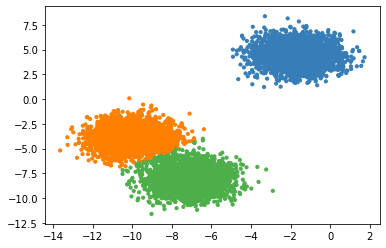

In [33]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(x[:, 0], x[:, 1], s=10, color=colors[labelsPred.tolist()])
plt.show()
# plt.clf()